In [1]:
import numpy as np

# Load the NPY file
data = np.load("./../data/bounding_box_2d_tight_0095.npy")
data.dtype

dtype([('semanticId', '<u4'), ('x_min', '<i4'), ('y_min', '<i4'), ('x_max', '<i4'), ('y_max', '<i4'), ('occlusionRatio', '<f4')])

In [2]:
import json

with open("../data/bounding_box_2d_tight_labels_0295.json", "r") as f:
    labels = json.load(f)
labels

{'0': {'class': 'forklift'},
 '1': {'class': 'rack'},
 '2': {'class': 'crate'},
 '3': {'class': 'floor'},
 '4': {'class': 'railing'},
 '5': {'class': 'pallet'},
 '6': {'class': 'stillage'},
 '7': {'class': 'iwhub'},
 '8': {'class': 'dolly'}}

In [3]:
with open("../data/bounding_box_2d_tight_prim_paths_0000.json", "r") as f:
    paths = json.load(f)
paths

['/World/forklift/scene',
 '/World/forklift/scene_05',
 '/World/forklift/scene_07',
 '/World/rack_crates/RackLarge_A7_16/RackLargeEmpty_A1',
 '/World/rack_crates/RackLarge_A7_16/WoodenCrate_B2',
 '/World/rack_crates/RackLarge_A7_17/RackLargeEmpty_A1',
 '/World/rack_crates/RackLarge_A7_17/WoodenCrate_B2',
 '/World/rack_crates/RackLarge_A7_18/RackLargeEmpty_A1',
 '/World/rack_crates/RackLarge_A7_18/WoodenCrate_B1',
 '/World/rack_crates/RackLarge_A7_20/RackLargeEmpty_A1',
 '/World/crate/WoodenCrate_D1_20']

In [4]:
import os
import shutil


def organizeDataByImageNumber(data_folder):
    """
    Organizes data into separate folders based on image number.

    Args:
      data_folder: The path to the folder containing the data.
    """

    # Define file patterns
    image_pattern = "rgb_*.png"
    bounding_box_labels_pattern = "bounding_box_2d_tight_labels_*.json"
    tight_prim_path_pattern = "bounding_box_2d_tight_prim_paths_*.json"
    segmentation_image_pattern = "semantic_segmentation_*.png"
    segmentation_label_pattern = "semantic_segmentation_labels_*.json"
    bounding_boxes_patter = "bounding_box_2d_tight_*.npy"
    # Get a list of image files
    image_files = [f for f in os.listdir(data_folder) if f.startswith("rgb_")]

    for image_file in image_files:
        # Extract the number from the image file name
        number = image_file[4:8]

        # Create the output folder
        output_folder = os.path.join(data_folder, number)
        os.makedirs(output_folder, exist_ok=True)

        # Construct other file names
        bounding_box_labels_file = f"bounding_box_2d_tight_labels_{number}.json"
        tight_prim_path_file = f"bounding_box_2d_tight_prim_paths_{number}.json"
        segmentation_image_file = f"semantic_segmentation_{number}.png"
        segmentation_label_file = f"semantic_segmentation_labels_{number}.json"
        bounding_box_file = f"bounding_box_2d_tight_{number}.npy"

        # Move files to the output folder
        shutil.move(os.path.join(data_folder, image_file), output_folder)
        shutil.move(os.path.join(data_folder, bounding_box_file), output_folder)
        shutil.move(os.path.join(data_folder, tight_prim_path_file), output_folder)
        shutil.move(os.path.join(data_folder, segmentation_image_file), output_folder)
        shutil.move(os.path.join(data_folder, segmentation_label_file), output_folder)


# Example usage
# data_folder = "../data"
# organizeDataByImageNumber(data_folder)

In [5]:
import json
import os
import numpy as np


def generate_bounding_boxes_data(data_folder):
    """
    Generate bounding boxes data from the files in the data folder for fine-tuning YOLOv7.
    Args:
      data_folder: The path to the folder containing the data.
    """
    # Define file patterns
    bounding_box_labels_pattern = "bounding_box_2d_tight_labels_*.json"
    bounding_boxes_pattern = "bounding_box_2d_tight_*.npy"
    # Get a list of bounding box label files
    bounding_box_label_files = [
        f
        for f in os.listdir(data_folder)
        if f.startswith("bounding_box_2d_tight_labels_")
    ]
    bounding_boxes_data = []
    for label_file in bounding_box_label_files:
        number = label_file.split("_")[-1].split(".")[0]
        bounding_box_file = f"bounding_box_2d_tight_{number}.npy"
        with open(os.path.join(data_folder, label_file), "r") as f:
            label_data = json.load(f)
        bounding_box_data = {
            "image_file": f"rgb_{number}.png",
            "bounding_box_labels": label_data,
            "bounding_box_data": np.load(os.path.join(data_folder, bounding_box_file)),
        }
        bounding_boxes_data.append(bounding_box_data)
    return bounding_boxes_data


# Example usage
data_folder = "../data"
bounding_boxes_data = generate_bounding_boxes_data(data_folder)

In [6]:
bounding_boxes_data[0]["image_file"]

'rgb_0295.png'

In [7]:
import os
import json


def map_class_names_to_ids(data_folder):
    class_mapping = {}
    class_id = 0
    counter = 0
    names = set()
    # Iterate through all files in the data directory
    for file in os.listdir(data_folder):
        counter = counter + 1
        if file.startswith("bounding_box_2d_tight_labels_") and file.endswith(".json"):
            with open(os.path.join(data_folder, file), "r") as f:
                labels = json.load(f)
                for label in labels.values():
                    class_name = label["class"]
                    names.add(class_name)
                    if class_name not in class_mapping:
                        class_mapping[class_name] = class_id
                        class_id += 1
    return class_mapping


# Example usage
data_folder = "../data"
class_mapping = map_class_names_to_ids(data_folder)
print(class_mapping)

{'forklift': 0, 'rack': 1, 'crate': 2, 'floor': 3, 'railing': 4, 'pallet': 5, 'stillage': 6, 'iwhub': 7, 'dolly': 8}


In [8]:
import os
import yaml
import shutil


def save_yolov7_format_data(bounding_boxes_data, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for data in bounding_boxes_data:
        image_file = data["image_file"]

        bounding_box_labels = data["bounding_box_labels"]
        bounding_box_data = data["bounding_box_data"]

        bounding_box_labels = {
            int(id): className["class"] for id, className in bounding_box_labels.items()
        }
        yolo_data = []
        for box_data in bounding_box_data:
            class_id = box_data["semanticId"]
            x_center = (box_data["x_min"] + box_data["x_max"]) / 2
            y_center = (box_data["y_min"] + box_data["y_max"]) / 2
            width = box_data["x_max"] - box_data["x_min"]
            height = box_data["y_max"] - box_data["y_min"]
            # Normalize to [0, 1] based on image dimensions (assuming image size is known)
            image_width, image_height = (
                1280,
                720,
            )  # Replace with actual image dimensions
            x_center /= image_width
            y_center /= image_height
            width /= image_width
            height /= image_height
            yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")
        shutil.copy(f"../data/{image_file}", output_folder)
        yolo_file_path = os.path.join(output_folder, image_file.replace(".png", ".txt"))
        with open(yolo_file_path, "w") as f:
            for line in yolo_data:
                f.write(line + "\n")


# Example usage
output_folder = "../yolov7/yolov7_data"
save_yolov7_format_data(bounding_boxes_data[:200], output_folder)

In [9]:
import os
import shutil
import random


def split_data(source_dir, train_ratio, val_ratio, test_ratio):

    # Create output directories
    train_dir = os.path.join(source_dir, "train/images")
    val_dir = os.path.join(source_dir, "val/images")
    test_dir = os.path.join(source_dir, "test/images")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create label directories
    os.makedirs(os.path.join(source_dir, "train/labels"), exist_ok=True)
    os.makedirs(os.path.join(source_dir, "val/labels"), exist_ok=True)
    os.makedirs(os.path.join(source_dir, "test/labels"), exist_ok=True)
    # Get a list of all image files
    image_files = [f for f in os.listdir(source_dir) if f.endswith(".png")]

    # Shuffle the image files
    random.shuffle(image_files)

    # Calculate split indices
    total_size = len(image_files)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    # Split the data into train, validation, and test sets
    train_files = image_files[:train_size]
    val_files = image_files[train_size : train_size + val_size]
    test_files = image_files[train_size + val_size :]
    # Copy files to respective directories
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), train_dir)
        shutil.move(
            os.path.join(source_dir, file.replace(".png", ".txt")),
            os.path.join(source_dir, "train/labels"),
        )
    for file in val_files:
        shutil.move(os.path.join(source_dir, file), val_dir)
        shutil.move(
            os.path.join(source_dir, file.replace(".png", ".txt")),
            os.path.join(source_dir, "val/labels"),
        )
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), test_dir)
        shutil.move(
            os.path.join(source_dir, file.replace(".png", ".txt")),
            os.path.join(source_dir, "test/labels"),
        )


source_dir = "./yolov7_data"
split_data(source_dir, 0.7, 0.2, 0.1)

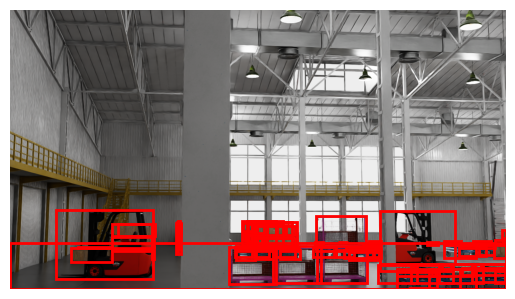

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_image_with_boxes(image_path, bounding_boxes):
    """
    Displays an image with bounding boxes.

    Args:
        image_path: Path to the image file.
        bounding_boxes: List of bounding boxes in the format [id, xmin, ymin, xmax, ymax, occlusion].
    """
    # Load the image
    image = Image.open(image_path)
    plt.imshow(image)

    # Plot each bounding box
    for box in bounding_boxes:
        id, xmin, ymin, xmax, ymax, occlusion = box

        plt.gca().add_patch(
            plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                edgecolor="red",
                facecolor="none",
                linewidth=2,
            )
        )
        # plt.text(
        #     xmin,
        #     ymin,
        #     str(id),
        #     color="white",
        #     fontsize=12,
        #     bbox=dict(facecolor="red", alpha=0.5),
        # )

    plt.axis("off")  # Hide axes
    plt.show()


# Example usage
image_path = "./../data/rgb_0095.png"
bounding_boxes = list(data)
display_image_with_boxes(image_path, bounding_boxes)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def plot_bounding_boxes(image_path, bounding_boxes):
    """
    Plots bounding boxes on an image.

    Args:
      image_path: Path to the image file.
      bounding_boxes: List of bounding boxes in the format (x_center, y_center, width, height).
    """

    # Load the image
    image = Image.open(image_path)
    plt.imshow(image)

    # Convert bounding boxes to xmin, ymin, xmax, ymax
    for x_center, y_center, width, height in bounding_boxes:
        xmin = int(x_center - width / 2)
        ymin = int(y_center - height / 2)
        xmax = int(x_center + width / 2)
        ymax = int(y_center + height / 2)

        # Plot the bounding box
        rect = plt.Rectangle(
            (xmin, ymin), width, height, fill=False, edgecolor="red", linewidth=2
        )
        plt.gca().add_patch(rect)

    plt.axis("off")
    plt.show()


# Example usage
image_path = "./yolov7_data/val/images/rgb_0048.png"
with open("./yolov7_data/val/labels/rgb_0048.txt", "r") as file:
    lines = file.readlines()
    lines = [line.strip().split() for line in lines]

bounding_boxes = []
for box in lines:
    _, x_center, y_center, width, height = box
    bounding_boxes.append(
        (
            float(x_center) * 1280,
            float(y_center) * 720,
            float(width) * 1280,
            float(height) * 720,
        )
    )
plot_bounding_boxes(image_path, bounding_boxes)

FileNotFoundError: [Errno 2] No such file or directory: './yolov7_data/val/labels/rgb_0048.txt'